## Chapter 4: Model-Free Prediction


Compared to **Dynamics Programming**, **Model-free prediction** algorithms aim to estimate the **value function of a certain policy** *without knowing the MDP*. Mainly, **Monte-Carlo Prediction** and **Temporal-Difference learning (TD-learning)** are known as a **model-free** prediction algorithms. 

### Monte-Carlo Prediction

According to Wikipedia, **Monte-Carlo (MC)** method is a broad class of algorithms that repeated random sampling to obtain numerical results. For example, the value of $\pi$ can be approximated using a Monte Carlo method, by uniformly scattering number of points over the square. 

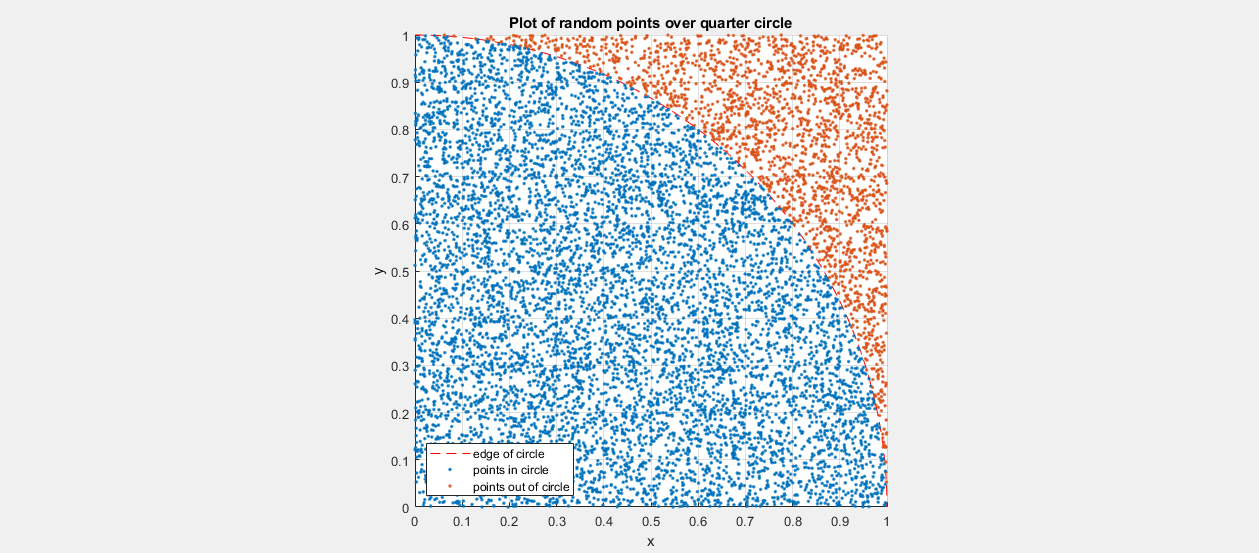

In Reinforcement Learning, it can be used to evaulate the value function of the policy $\pi$ by sampling return of multiple episodes.
</br>
</br>
<font size="4">
$$\begin{align}
v_\pi(s) = \mathbb{E}_\pi[G_t |S_t = s]
\end{align}$$
</font>

where return $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots \gamma^{T-1} R_T$. 

Monte-Carlo policy evaluation consider empirical mean return as value. 

After an episode end, we can update the value of the states visited in the episode. Value of the states can be updated by average of the returns following the first visits to the states (*First-Visit* MC), or every visits to the states (*Every-Visit* MC). 

For example, we can record **list of total returns $G_t$** by the first timestep, or every timestep $t$ that state $s$ is visited in an episode, and estimate its value by average of returns.  


Both first-visit and every-visit MC converge to true value function $v_\pi$ with finite variance.


### Incremental Monte-Carlo Updates

Monte-Carlo prediction requires list of total returns in order to calculate average of returns. 
However, recording the history of total returns for every states can be avoided by implementing incremental mean.
</br>
</br>
<font size="4">
$$\begin{align}
\mu_k = \frac{1}{k} \sum_{j=1}^k x_j = \frac{1}{k}(x_k + \sum_{j=1}^{k-1} x_j) & \\ =\frac{1}{k}(x_k + (k-1)\mu_{k-1}) \\ = \mu_{k-1} + \frac{1}{k}(x_k - \mu_{k-1})
\end{align}$$
</font>

Monte-Carlo value $V(s)$ can be updated by using incremental mean as following. 
</br>
</br>
<font size="4">
$$\begin{align}
V(S_t) = V(S_t) + \frac{1}{N(S_t)}(G_t - V(S_t))
\end{align}$$
</font>
where $N(S_t)$ is a number of times $V(S_t)$ is updated. 

In non-stationary problems, $\frac{1}{N(S_t)}$ is usually replaced to constant hyperparameter $\alpha \in [0, 1]$ to keep track of a runnning mean. 
</br>
</br>
<font size="4">
$$\begin{align}
V(S_t) = V(S_t) + \alpha(G_t - V(S_t))
\end{align}$$
</font>

In this case, which is called constant-$\alpha$ MC, hyperparameter $\alpha$ acts as a step-size for MC value update. If $\alpha = 0$, $V(S_t)$ will not be updated by the policy, and if $\alpha = 1$, $V(S_t)$ is equal to the last return experienced by the policy.  


### Pseudocode and Implementation of Monte-Carlo prediction

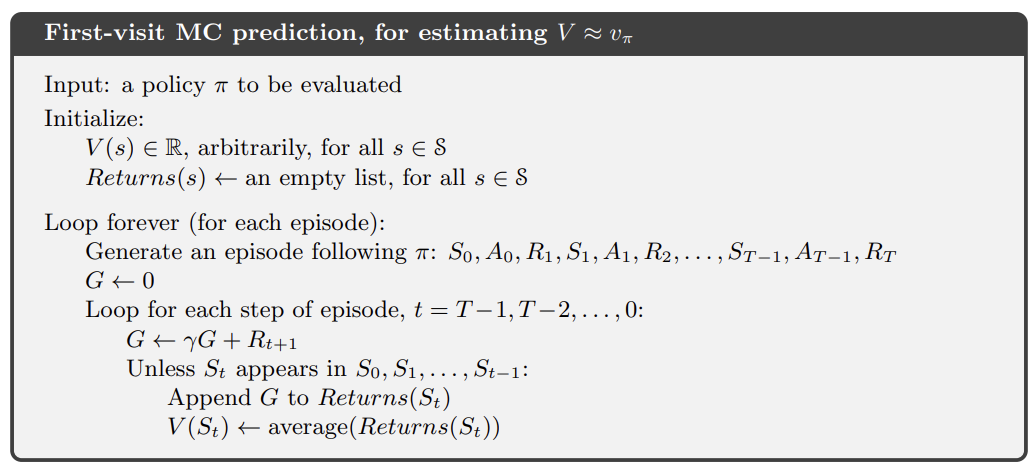

In [1]:
import gymnasium as gym
import numpy as np
from utils import JupyterRender

%matplotlib inline

In [2]:
class MC_prediction:
    def __init__(self, env, pi, gamma=0.9, max_episode=100, render=False):
        self.env = env
        
        self.nrow = env.nrow
        self.ncol = env.ncol 
        
        self.state_dim = env.observation_space.n # self.nrow * self.ncol
        self.action_dim = env.action_space.n

        self.gamma = gamma
        self.max_episode = max_episode
        self.render = render
        
        self.pi = pi
        self.v = np.zeros([self.state_dim])
        self.returns = [[] for _ in range(self.state_dim)]
        
        #check policy validity
        assert len(self.pi) == self.state_dim
        
        for i in range(self.state_dim):
            assert self.pi[i] >= 0 and self.pi[i] < self.action_dim
            
    def run(self):
        for episode in range(self.max_episode):
            observation, _ = self.env.reset()
            
            done = False
            local_step = 0
            trajectory = []
            
            while not done:
                action = self.pi[observation]
                next_observation, reward, done, _, _ = self.env.step(action)
                
                if self.render:
                    self.env.render(title=f"Episode {episode} / step {local_step}",v=self.v, policy=self.pi)
                # give penalty for staying in ground
                if reward == 0:
                    reward = -0.001
                    
                # give penalty for falling into the hole
                if done and next_observation != 15:
                    reward = -1

                if local_step == 100:
                    done = True #prevent infinite episode
                    reward = -1

                if observation == next_observation: # prevent meaningless actions
                    reward = -1

                trajectory.append({'s': observation, 'a': action, 'r': reward})
                
                observation = next_observation 
                local_step += 1
            trajectory.reverse()
            G = 0
            
            traj_states = list(map(lambda x: x['s'], trajectory))
            
            for i in range(len(trajectory)):
                G = self.gamma * G + trajectory[i]['r'] 
                
                if trajectory[i]['s'] not in traj_states[i+1:]:
                    self.returns[trajectory[i]['s']].append(G)
                    self.v[trajectory[i]['s']] = sum(self.returns[trajectory[i]['s']]) / len(self.returns[trajectory[i]['s']])
                
            
                
            

In [3]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

policy = np.array([1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0], dtype=int) #optimal policy


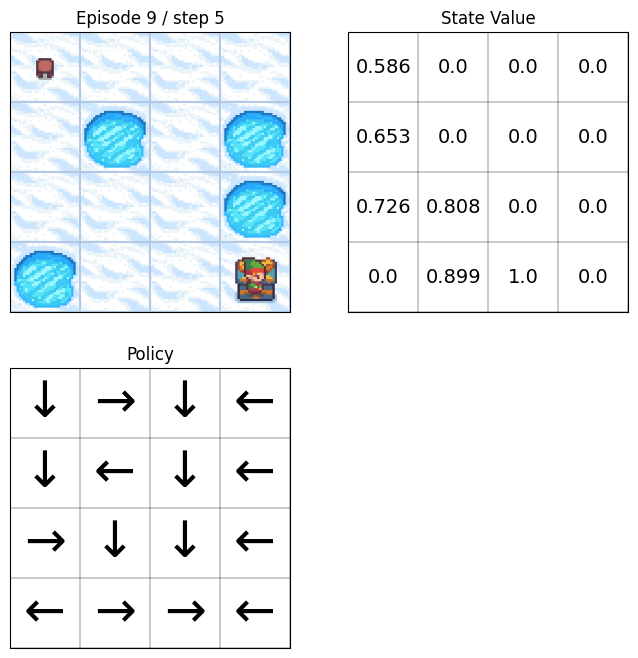

In [4]:
mc_config = {
    'env': env,
    'pi': policy,
    'gamma': 0.9,
    'render': True,
    'max_episode': 10
}

mc = MC_prediction(**mc_config)
mc.run()

### Temporal-Difference Learning

**Temporal-Difference (TD)** learning is a model-free learning algorithm that learns by bootstrapping from the current estimate of the value function. 

</br>
</br>
<font size="4">
$$\begin{align}
v_\pi(s) = \mathbb{E}_\pi[G_t |S_t = s]  & \\ = \mathbb{E}_\pi[\sum_{k=0}^{T-1}\gamma^k R_{t+k+1} |S_t = s] \\= \mathbb{E}_\pi[R_{t+1} + \gamma \sum_{k=0}^{T-2}\gamma^{k} R_{t+k+2} |S_t = s] \\=
\mathbb{E}_\pi [R_{t+1} + \gamma v_\pi(s_{t+1}) | S_t = s]
\end{align}$$
</font>

Temporal-Difference learning updates value $V(S_t)$ towards estimated return $R_{t+1} + \gamma V(S_{t+1})$.
</br>
</br>
<font size="4">
$$\begin{align}
V(S_t) = V(S_t) + \alpha(R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{align}$$
</font>

$R_{t+1} + \gamma V(S_{t+1})$ is often called the **TD target**, and $\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ as the **TD error**.


### Pseudocode and Implementation of Temporal-Difference learning

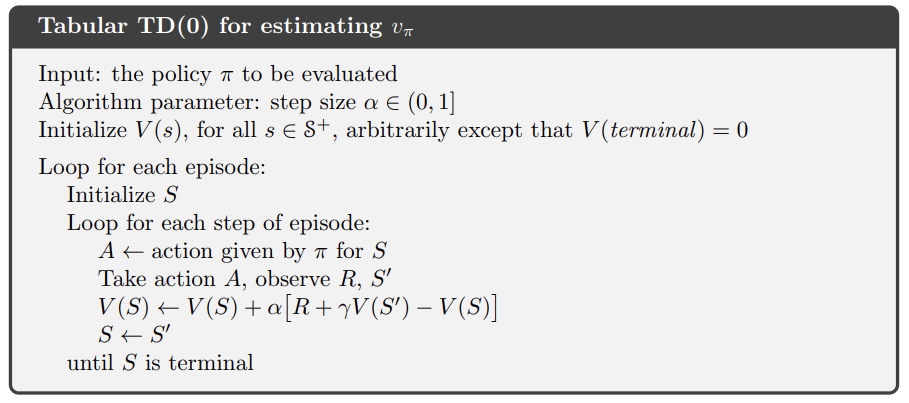

In [5]:
import gymnasium as gym
import numpy as np
from utils import JupyterRender

%matplotlib inline

In [6]:
class TD_learning:
    def __init__(self, env, pi, alpha=0.1, gamma=0.9, max_episode=100, render=False):
        self.env = env
        
        self.nrow = env.nrow
        self.ncol = env.ncol 
        
        self.state_dim = env.observation_space.n # self.nrow * self.ncol
        self.action_dim = env.action_space.n

        self.alpha = alpha
        self.gamma = gamma
        self.max_episode = max_episode
        self.render = render
        
        self.pi = pi
        self.v = np.zeros([self.state_dim])
        
        #check policy validity
        assert len(self.pi) == self.state_dim
        
        for i in range(self.state_dim):
            assert self.pi[i] >= 0 and self.pi[i] < self.action_dim
        
    def run(self):
        for episode in range(self.max_episode):
            observation, _ = self.env.reset()
            
            done = False
            local_step = 0
            while not done:
                action = self.pi[observation]
                next_observation, reward, done, _, _ = self.env.step(action)
                
                if self.render:
                    self.env.render(title=f"Episode {episode} / step {local_step}",v=self.v, policy=self.pi)

                # give penalty for staying in ground
                if reward == 0:
                    reward = -0.001
                    
                # give penalty for falling into the hole
                if done and next_observation != 15:
                    reward = -1

                if local_step == 100:
                    done = True #prevent infinite episode
                    reward = -1

                if observation == next_observation: # prevent meaningless actions
                    reward = -1

                self.v[observation] += self.alpha * (reward + self.gamma * self.v[next_observation] - self.v[observation])
                
                observation = next_observation
                local_step += 1

In [7]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

policy = np.array([1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0], dtype=int) #optimal policy


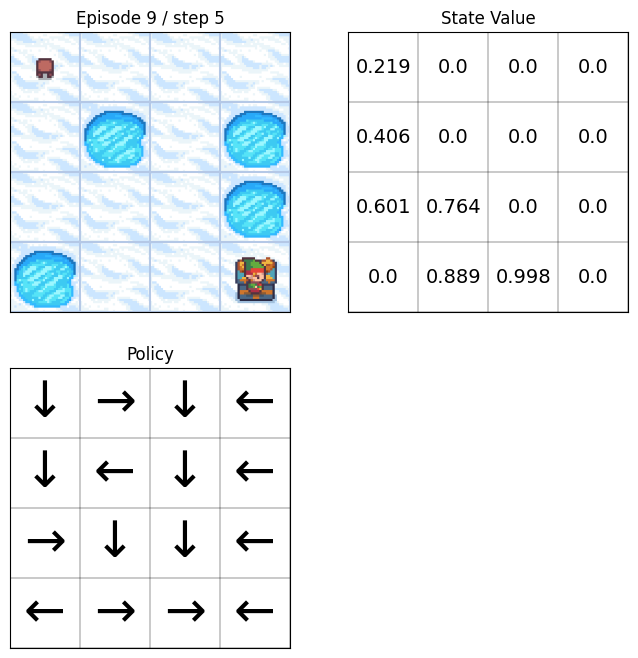

In [8]:
td_config = {
    'env': env,
    'pi': policy,
    'gamma': 0.9,
    'alpha': 0.5,
    'render': True,
    'max_episode': 10
}

td = TD_learning(**td_config)
td.run()

### Difference between Monte-Carlo (MC) and Temporal-Difference (TD) 

Even though MC and TD are both model-free learning algorithms, they have many differences.

- **MC** must wait until the episode ends to calculate return $\longleftrightarrow$  **TD** can learn before the episode ends 
-  **Return** $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots \gamma^{T-1} R_T$ is **unbiased** estimate of $v_\pi(S_t)$ $\longleftrightarrow$ **TD target** $R_{t+1} + \gamma V(S_{t+1})$ is **biased** estimate of $v_\pi(S_t)$
- **Return** has **high variance** $\longleftrightarrow$ **TD target** has much **lower variance** than return
- High variance and zero bias makes **MC** insensitive to initial value $\longleftrightarrow$ Low variance and some bias makes **TD** more efficient than **MC**, but also more sensitive to initial value 
- **MC** does not bootstrap and exploit Markov property $\longleftrightarrow$ **TD** bootstraps and exploits Markov property

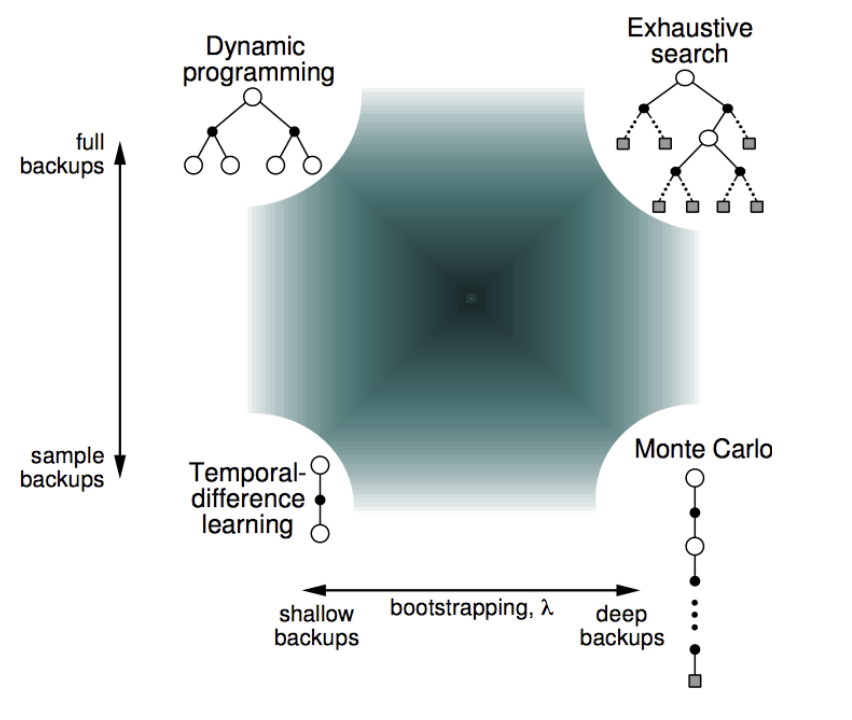

**MC** and **TD** both utilizes sample backup unlike **DP**, but differs in boostrapping.